# Import libraries

In [1]:
!wget https://www.cs.jhu.edu/~mdredze/datasets/sentiment/unprocessed.tar.gz

--2024-02-01 11:46:08--  https://www.cs.jhu.edu/~mdredze/datasets/sentiment/unprocessed.tar.gz
Resolving www.cs.jhu.edu (www.cs.jhu.edu)... 

128.220.13.64
Connecting to www.cs.jhu.edu (www.cs.jhu.edu)|128.220.13.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1586365438 (1.5G) [application/x-gzip]
Saving to: ‘unprocessed.tar.gz’

unprocessed.tar.gz  100%[===================>]   1.48G  1.57MB/s    in 8m 55s  

2024-02-01 11:55:04 (2.83 MB/s) - ‘unprocessed.tar.gz’ saved [1586365438/1586365438]



In [2]:
%%capture
!tar -xvf unprocessed.tar.gz

In [4]:
import sys
sys.path.append('..')

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from sentiment_analysis.data.data_extraction import extract_reviews_and_ratings_to_dataframe
from sentiment_analysis.data.data_balancing import balance_dataframe
from sentiment_analysis.utils.text_vectorizer import TextVectorizer
from sentiment_analysis.utils.generate_report import add_model_report
from sentiment_analysis.utils.visualization import plot_confusion_matrix

from sklearn.model_selection import train_test_split

# Data pre-processing

This code cell aggregates product reviews and ratings from different categories into a single DataFrame. It navigates through a dataset containing categorized 'all.review' files, extracts their data, and compiles it for consolidated analysis.

In [7]:
# Initialize an empty DataFrame to store all reviews
all_reviews_df = pd.DataFrame()

# Set the path to the dataset directory
dataset_path = 'sorted_data'

# Iterate over each category directory in the dataset path
for category in os.listdir(dataset_path):
  # Create the full path to the current category directory
  category_path = os.path.join(dataset_path, category)

  # Check if the current path is a directory (and not a file)
  if os.path.isdir(category_path):
    # Iterate over each file or directory within the category directory
    for data in os.listdir(category_path):

      # Check if the current item is the 'all.review' file
      if data == 'all.review':
        # Construct the full path to the 'all.review' file
        data_path = os.path.join(category_path, data)
        # Extract reviews and ratings from the file and store them in a DataFrame
        df = extract_reviews_and_ratings_to_dataframe(data_path, category)
        # Concatenate the new DataFrame with the existing reviews DataFrame
        all_reviews_df = pd.concat([all_reviews_df, df], ignore_index=True)

## Products rating analysis

This code cell displays the summary information of the aggregated DataFrame `all_reviews_df`, which contains the compiled product reviews, ratings, and a binarized review class.

In [8]:
all_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1277462 entries, 0 to 1277461
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   review_text   1277462 non-null  object
 1   rating        1277462 non-null  object
 2   category      1277462 non-null  object
 3   review_class  1277462 non-null  object
dtypes: object(4)
memory usage: 39.0+ MB



This code cell analyzes the distribution of product ratings within the all_reviews_df DataFrame. It calls the `value_counts()` method on the `'rating'` column to count the occurrences of each unique rating value

In [9]:
all_reviews_df['rating'].value_counts()

rating
5.0    825089
4.0    287950
1.0     92375
2.0     72048
Name: count, dtype: int64

The output displays a count of each rating score, revealing potential class imbalance within the dataset. A class imbalance is evident as the rating of 5.0 significantly outnumbers the other ratings, which could affect the performance of models trained on this data, as they may become biased towards the more frequent classes. Models may perform well in predicting the majority class but poorly on minority classes.

Now, calculates the frequency of each class within the `'review_class'` column of the all_reviews_df

In [10]:
all_reviews_df['review_class'].value_counts()

review_class
1    1113039
0     164423
Name: count, dtype: int64

The results indicate the presence of a class imbalance between the two classes within the `review_class` column. Class 1 has a substantially higher count compared to class 0, which can lead to biases. However, using this column for binary classification seems to be better than using only the base ratings, a similar division process was followed in [1].

## Categories analysis

The code cell executes a value count operation on the `'category'` column of the `all_reviews_df` DataFrame to quantify the number of reviews per category.

In [11]:
all_reviews_df['category'].value_counts()

category
books                     913899
music                     149567
dvd                       111789
video                      33130
electronics                21761
toys_&_games               11601
apparel                     8740
sports_&_outdoors           5305
baby                        3806
magazines                   3723
beauty                      2666
computer_&_video_games      2605
grocery                     2391
software                    2088
outdoor_living              1504
gourmet_food                1463
automotive                   702
office_products              393
musical_instruments          329
Name: count, dtype: int64

The output indicates a diverse range of product categories, with `'books'` having the highest number of reviews. This distribution is essential for understanding the multi-domain aspect of the dataset. It also highlights the potential need for stratified sampling or rebalancing techniques to address the uneven representation of categories in the training data.

The cell executes a command to randomly sample 20 entries from the all_reviews_df DataFrame. This provides a quick representation of the data, showcasing the review text, ratings, categories, and their associated class.

In [12]:
all_reviews_df.sample(20)

,review_text,rating,category,review_class
1245639,I remember what happened to me when i first li...,5.0,music,1
219793,Mr. Fishman is straight-forward in delivering ...,5.0,books,1
224813,This book is no joke. It is really freaky and ...,5.0,books,1
942829,This book is packed with very useful informati...,5.0,books,1
809096,"As an OT student, I've used this book more in ...",5.0,books,1
1100257,This book is utterly awful. It is filled with ...,1.0,books,0
475461,"""The Martians have arrived. Let the war begin....",5.0,books,1
416549,Being gifted doesn't mean you know everything ...,5.0,books,1
669116,Mazny years ago the famed author Dr. Alvin Toe...,5.0,books,1
1246829,Have many Greatest Hits by the Righteous Broth...,5.0,music,1


With the data sampling, we observe that categories with fewer reviews might require special attention to avoid model bias. As a strategic next step, we consider selecting the top five most voluminous categories for training the classifiers to ensure robust performance across the dataset's most represented domains.

In [13]:
top_categories = all_reviews_df['category'].value_counts().nlargest(5).index
top_categories

Index(['books', 'music', 'dvd', 'video', 'electronics'], dtype='object', name='category')

 Iterates over the top_categories list, filtering the `all_reviews_df` DataFrame to create subsets of data specific to each category.

In [14]:
category_dfs = {category: all_reviews_df[all_reviews_df['category'] == category] for category in top_categories}
books_df = category_dfs['books']
music_df = category_dfs['music']
dvd_df = category_dfs['dvd']
video_df = category_dfs['video']
electronics_df = category_dfs['electronics']

The following cell will show the distribution of review counts across the top categories.

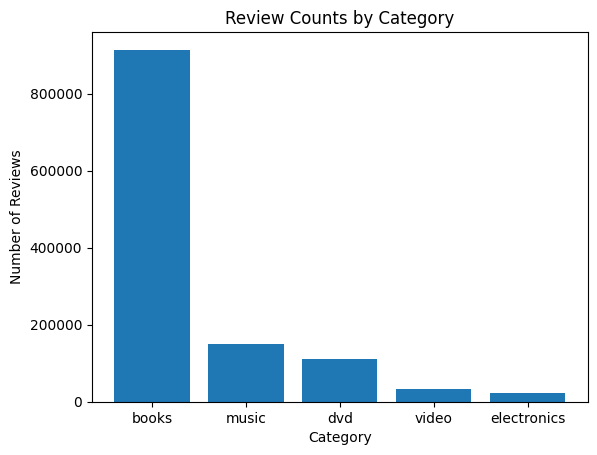

In [15]:
categories = ['books', 'music', 'dvd', 'video', 'electronics']
review_counts = [len(books_df), len(music_df), len(dvd_df), len(video_df), len(electronics_df)]

plt.bar(categories, review_counts)
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.title('Review Counts by Category')
plt.show()

The resulting bar chart offers a comparative perspective on the number of reviews per category. It clearly demonstrates that the `'books'` category dominates the dataset with a significantly higher review count, followed by a steep drop-off in volume for the remaining categories.

In [16]:
dataframes = [books_df, music_df, dvd_df, video_df, electronics_df]
categories = ['Books', 'Music', 'DVD', 'Video', 'Electronics']

Append dataframes to new list for future easy data manipulation. Also, assigns each a category tag.

This code cell iterates over a collection of DataFrames, each corresponding to a different product category, and calculates the frequency of each class within the review_class column for each category.

In [17]:
for i, df in enumerate(dataframes):
  print(f"Dataframe: {categories[i]}")
  print(df['review_class'].value_counts(), '\n')

Dataframe: Books
review_class
1    797413
0    116486
Name: count, dtype: int64 

Dataframe: Music
review_class
1    136667
0     12900
Name: count, dtype: int64 

Dataframe: DVD
review_class
1    95854
0    15935
Name: count, dtype: int64 

Dataframe: Video
review_class
1    27911
0     5219
Name: count, dtype: int64 

Dataframe: Electronics
review_class
1    16969
0     4792
Name: count, dtype: int64 



The printed output offers a clear breakdown of sentiment classes across different categories, revealing significant class imbalances within each one

## Dataset Balancing

The code in this cell apply the function balance_dataframe to each category-specific DataFrame within a collection named dataframes. After balancing, proceeds to drop the `'rating'` and `'category'` columns to streamline the data for classification purposes.

In [18]:
balanced_dataframes = [balance_dataframe(df, 'review_class', random_state=123).drop('rating', axis=1).drop('category', axis=1) for df in dataframes]

In [19]:
balanced_dataframes[0].sample(20)

,review_text,review_class
114301,"ustedes me dijeron que no tenian el libro,.¿qu...",0
53536,"HB: ""How did you come to name this collection ...",1
97993,Please do not be decieved into believing the l...,0
244339,How could a foodie like me not love this book?...,1
87191,I am always surprised that J.A. Jance is able ...,1
42700,"""The neo-conservatives run the Pentagon"", so s...",0
134215,I was somehow forced to rate the book one star...,0
219790,"We found the facinating, with places we never ...",1
138801,"If you are a man, and you are deeply suffering...",1
153076,"Dr. Yahnke's book is very accessible, love her...",1


In [20]:
for i, df in enumerate(balanced_dataframes):
  print(f"Dataframe: {categories[i]}")
  print(df['review_class'].value_counts(), '\n')

Dataframe: Books
review_class
1    150532
0    150532
Name: count, dtype: int64 

Dataframe: Music
review_class
0    19088
1    19088
Name: count, dtype: int64 

Dataframe: DVD
review_class
1    19930
0    19930
Name: count, dtype: int64 

Dataframe: Video
review_class
0    6353
1    6353
Name: count, dtype: int64 

Dataframe: Electronics
review_class
1    5400
0    5400
Name: count, dtype: int64 



The output shows an equal number of positive (1) and negative (0) review classes for each category, confirming the successful application of the balancing process.

# Training and Test data preparation

Iterates through each DataFrame in balanced_dataframes to perform a train-test split. This split is stratified by the `review_class` column to maintain the balanced class distribution in both training and testing sets.

In [21]:
all_datasets = []

for df in balanced_dataframes:
  all_datasets.append(train_test_split(df, stratify=df['review_class'], test_size=0.2, random_state=42))

In [22]:
for i, dataset in enumerate(all_datasets):
  print(f'Dataset: {categories[i]}')
  print(f'Training: {len(dataset[0])}')
  print(f'Test: {len(dataset[1])}', '\n')

Dataset: Books
Training: 240851
Test: 60213 

Dataset: Music
Training: 30540
Test: 7636 

Dataset: DVD
Training: 31888
Test: 7972 

Dataset: Video
Training: 10164
Test: 2542 

Dataset: Electronics
Training: 8640
Test: 2160 



The printed output provides a concise summary of the number of samples in the training and test datasets for each category.

# Classification Models Training

## Book Category classification

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import classification_report

Obtain the book category corresponding data for training and evaluation.

In [ ]:
book_training_dataset = all_datasets[0][0]
book_test_dataset = all_datasets[0][1]

In [ ]:
book_training_dataset

,review_text,review_class
135962,This book is one of the most interesting that ...,1
152816,Pascual Duarte grew up in brutal and brutalizi...,1
51840,"I also reviewed Graysmith's ""Zodiac"" and said ...",0
280295,"Although Robin McKinley's stock heroine of ""ta...",0
174311,An interesting book if you are curious about e...,1
...,...,...
130482,Is our current administration intentionally ly...,1
128979,This book is a self-indulgent wallow in the mi...,0
263660,The Voyages of Dr. Dolittle is the story of a ...,1
122064,Love them! This one is so cute! We can't wait...,1


In [ ]:
book_test_dataset

,review_text,review_class
86965,I got this one for a steal - about half of wha...,1
105021,If we are to draw equivalent lessons from both...,0
43969,Spoiler alert!!\n\nThis book was a waste of my...,0
244775,"This book is way overated. Its way-out, wacky...",0
183602,We had to read this book for our Foundations c...,0
...,...,...
133803,This book is terrible. RaH takes a perfectly ...,0
227840,"While not as detailed as a textbook might be, ...",1
255603,This is a great buy. What an easy way to read...,1
13054,"A glorified cliche, this book does little just...",0


The variables `X_train` and `y_train` are being assigned. `X_train` is set to the `'review_text'` column of the book_training_dataset, which contains the text of the reviews. `y_train` is set to the `'review_class'` column of the same dataset and will serve as the target variable, indicating the class of the sentiment (positive or negative).

In [ ]:
X_train = book_training_dataset['review_text']
y_train = book_training_dataset['review_class']

In the same way, the variables X_test and y_test are assigned.

In [ ]:
X_test = book_training_dataset['review_text']
y_test = book_training_dataset['review_class']

The cell initializes an instance of the custom `TextVectorizer` class with its default configuration. This class encapsulates preprocessing and vectorization of textual data. Specifically, it **lemmatizes words**, **removes special characters**, and **represents text using TF-IDF (Term Frequency-Inverse Document Frequency) values**. The vectorizer is set to consider both unigrams and bigrams and is _limited to the 5000 most significant features_. If default English stopwords are used.

In [ ]:
text_vectorizer = TextVectorizer()

This cell applies the `fit_transform` method of the `text_vectorizer` instance to the X_train data. Converting the text data into a TF-IDF matrix where each row corresponds to a document and each column represents a term in the learned vocabulary.

In [ ]:
X_tfidf = text_vectorizer.fit_transform(X_train)

Print the shape of the resulting TF-IDF feature matrix

In [ ]:
print(X_tfidf.shape)

(240851, 5000)


Saves the books vectorizer for further use.

In [ ]:
text_vectorizer.save_vectorizer('text_vectorizer_books.joblib')

Apply the same transformation using the books vectorizer to the test data.

In [ ]:
X_test_tfidf = text_vectorizer.transform(X_test)

### Multinomial Naive Bayes Clasification

The following cell sets up a machine learning training pipeline using the `ModelTrainer` class, which encapsulates training and evaluation of scikit-learn models. An instance of the `ModelTrainer` class is created with a Multinomial Naive Bayes classifier and empty parameter settings. It then defines a parameter grid for alpha values to be used in a grid search, optimizing the smoothing parameter of the Naive Bayes algorithm.

In [ ]:
# Initialize an instance of the ModelTrainer class with Multinomial Naive Bayes classifier and parameters
trainer = ModelTrainer(MultinomialNB, {})

# Define the parameter grid for Grid Search
param_grid = {
  'alpha': [0.001, 0.01, 0.1, 1, 10, 100]  # Range of alpha values for smoothing parameter
}

# Train the model using Grid Search
# Grid Search will optimize the classifier to find the best alpha parameter based on cross-validation
trainer.train(X_tfidf, y_train, use_grid_search=True, grid_params=param_grid)

The resulting best model will be stored within the ModelTrainer instance, ready for evaluation and further use.

In [ ]:
# Evaluate the model
metrics = trainer.evaluate(X_test_tfidf, y_test)
print(metrics['report'])

              precision    recall  f1-score   support

           0       0.86      0.85      0.86    120425
           1       0.85      0.86      0.86    120426

    accuracy                           0.86    240851
   macro avg       0.86      0.86      0.86    240851
weighted avg       0.86      0.86      0.86    240851



The model shows an overall accuracy of 0.86, with balanced precision, recall, and f1-scores across both classes, indicating good performance in classifying both positive and negative sentiments. The macro and weighted averages are also 0.86, suggesting consistent performance across the classes, considering their support.

Save the best model for further use.

In [ ]:
trainer.save_model('multinomial_nb_model.pkl')

Load the saved model for testing correct saving

In [ ]:
multinomial_nb_model = trainer.load_model('multinomial_nb_model.pkl')

The function `add_model_report` generates a DataFrame containing the classification report for a model. It takes the true labels `y_true`, the predicted labels `y_pred`, and the model_name as arguments.

In [ ]:
metrics_df = add_model_report(y_test, multinomial_nb_model.predict(X_test_tfidf), 'MultinomialNB')

metrics_df

,model_name,class_label,accuracy,precision,recall,f1-score,support
0,MultinomialNB,0,0.857148,0.859704,0.853594,0.856638,120425.0
1,MultinomialNB,1,0.857148,0.854628,0.860703,0.857655,120426.0


The code cell defines a list of sample reviews, `sentiment_samples`, each labeled with a sentiment score to illustrate various levels of customer feedback, ranging from "very negative" to "very positive". These samples provide a qualitative glimpse into the types of textual data that a sentiment analysis model may encounter. Additionally, a list called sentiment_samples_true is defined, containing simplified binary sentiment labels corresponding to the reviews.

In [ ]:
sentiment_samples = [
    # Very Negative (1.0)
    "Absolutely disappointed with this blender. It stopped working after just two uses. Customer service was unhelpful, and there's no option for a refund or replacement. A total waste of money.",  # GT: 1.0
    "This smartphone case is a total letdown. It doesn't fit properly and offers zero protection. Dropped my phone once, and the screen shattered. Not worth it at all.",  # GT: 1.0

    # Negative (2.0)
    "Bought these headphones based on reviews, but they're just okay. The sound quality is mediocre, and they're quite uncomfortable for longer use. Not what I expected for the price.",  # GT: 2.0
    "This coffee maker is underwhelming. It brews coffee alright, but the design is flawed, making it messy and hard to clean. It's also slower than advertised.",  # GT: 2.0

    # Positive (4.0)
    "The gardening tool set is pretty good for the price. The tools are sturdy, although the handles could be more comfortable. Overall, a decent purchase for casual gardening.",  # GT: 4.0
    "This yoga mat is quite nice. It's durable and offers good grip, though a bit thinner than I prefer. It's great for regular use, though, and easy to clean.",  # GT: 4.0

    # Very Positive (5.0)
    "Love this laptop! It's fast, lightweight, and the battery life is impressive. Perfect for my work and entertainment needs. Totally worth the investment.",  # GT: 5.0
    "This electric toothbrush is fantastic. My teeth have never felt cleaner, and the different modes are very useful. Battery lasts long, and it's easy to use. Highly recommend.",  # GT: 5.0
    "The kitchen knife set is exceptional. Razor-sharp, well-balanced, and the handles are comfortable. They've made cooking much more enjoyable. A great buy.",  # GT: 5.0
    "This pet bed is a hit with my dog. It's soft, cozy, and durable. Easy to wash and keeps its shape. My dog loves it, and so do I. Great quality for the price."  # GT: 5.0
]

sentiment_samples_true = ['0', '0', '0', '0', '1', '1', '1', '1', '1', '1']

The code cell first vectorizes a list of new sentiment samples into TF-IDF features. Then it uses a pretrained Multinomial Naive Bayes model to predict the sentiment classes of these samples. Each sample text is printed along with its predicted class.

In [ ]:
# Transform the sentiment samples into TF-IDF features using the pre-fitted vectorizer
X_new_tfidf = text_vectorizer.transform(sentiment_samples)

# Predict the sentiment classes for the new samples
predicted = multinomial_nb_model.predict(X_new_tfidf)

# Print each sentiment sample with its corresponding predicted class
for doc, category in zip(sentiment_samples, predicted):
    print('%r\n\t => %s' % (doc, category))

# Generate the classification report comparing true labels and predicted labels
# Here 'Positive' is labeled as '1' and 'Negative' as '0'
report = classification_report(sentiment_samples_true, predicted, target_names=['Positive', 'Negative'], output_dict=False)
print(report)

"Absolutely disappointed with this blender. It stopped working after just two uses. Customer service was unhelpful, and there's no option for a refund or replacement. A total waste of money."
	 => 0
"This smartphone case is a total letdown. It doesn't fit properly and offers zero protection. Dropped my phone once, and the screen shattered. Not worth it at all."
	 => 0
"Bought these headphones based on reviews, but they're just okay. The sound quality is mediocre, and they're quite uncomfortable for longer use. Not what I expected for the price."
	 => 0
"This coffee maker is underwhelming. It brews coffee alright, but the design is flawed, making it messy and hard to clean. It's also slower than advertised."
	 => 1
'The gardening tool set is pretty good for the price. The tools are sturdy, although the handles could be more comfortable. Overall, a decent purchase for casual gardening.'
	 => 1
"This yoga mat is quite nice. It's durable and offers good grip, though a bit thinner than I pr

The output from the sentiment classification model showcases a commendable level of accuracy in identifying the polarity of sentiment in product reviews. The Multinomial Naive Bayes model has demonstrated a nuanced understanding of language cues, successfully distinguishing between positive and negative feedback in various contexts.

### Random Forest Classification

The next code cell trains a new model using the ModelTrainer class. It specifically sets up a Random Forest Classifier with defined parameters for maximum tree depth and random state for consistent results across runs.

In [ ]:
# Initialize an instance of ModelTrainer with RandomForestClassifier and specific parameters
trainer = ModelTrainer(RandomForestClassifier, {'max_depth': 26, 'random_state': 42})

# Train the model with the TF-IDF transformed training data and training labels
# X_tfidf contains the features, and y_train contains the labels for the training data
trainer.train(X_tfidf, y_train)

Evaluate the model

In [ ]:
metrics = trainer.evaluate(X_test_tfidf, y_test)
print(metrics['report'])

              precision    recall  f1-score   support

           0       0.93      0.85      0.89    120425
           1       0.86      0.93      0.90    120426

    accuracy                           0.89    240851
   macro avg       0.89      0.89      0.89    240851
weighted avg       0.89      0.89      0.89    240851



The classification report for the Random Forest Classifier shows a good performance, with an overall accuracy of 0.89, suggesting that the model is adept at correctly predicting sentiment 89% of the time. The precision of 0.93 for the negative class indicates that the model is particularly effective at identifying negative reviews, while the recall of 0.93 for the positive class suggests it is equally adept at capturing positive sentiments. Balanced f1-scores for both classes reflect a harmonious balance between precision and recall, pointing to the model's reliability in sentiment classification.

Save the model for further use

In [ ]:
trainer.save_model('random_forest_model.pkl')

Load the model for testing correct saving

In [ ]:
random_forest_model = trainer.load_model('random_forest_model.pkl')

In [ ]:
new_metrics_df = add_model_report(y_test, random_forest_model.predict(X_test_tfidf), 'Random Forest')
metrics_df = pd.concat([metrics_df, new_metrics_df]).reset_index(drop=True)

metrics_df

,model_name,class_label,accuracy,precision,recall,f1-score,support
0,MultinomialNB,0,0.857148,0.859704,0.853594,0.856638,120425.0
1,MultinomialNB,1,0.857148,0.854628,0.860703,0.857655,120426.0
2,Random Forest,0,0.890576,0.927412,0.847482,0.885647,120425.0
3,Random Forest,1,0.890576,0.859585,0.933669,0.895097,120426.0


Perform evaluation on `sentiment_samples` data

In [ ]:
# Transform the sentiment samples into TF-IDF features using the pre-fitted vectorizer
X_new_tfidf = text_vectorizer.transform(sentiment_samples)

# Predict the sentiment classes for the new samples
predicted = random_forest_model.predict(X_new_tfidf)

# Print each sentiment sample with its corresponding predicted class
for doc, category in zip(sentiment_samples, predicted):
    print('%r\n\t => %s' % (doc, category))

# Generate the classification report comparing true labels and predicted labels
# Here 'Positive' is labeled as '1' and 'Negative' as '0'
report = classification_report(sentiment_samples_true, predicted, target_names=['Positive', 'Negative'], output_dict=False)
print(report)

"Absolutely disappointed with this blender. It stopped working after just two uses. Customer service was unhelpful, and there's no option for a refund or replacement. A total waste of money."
	 => 0
"This smartphone case is a total letdown. It doesn't fit properly and offers zero protection. Dropped my phone once, and the screen shattered. Not worth it at all."
	 => 1
"Bought these headphones based on reviews, but they're just okay. The sound quality is mediocre, and they're quite uncomfortable for longer use. Not what I expected for the price."
	 => 0
"This coffee maker is underwhelming. It brews coffee alright, but the design is flawed, making it messy and hard to clean. It's also slower than advertised."
	 => 1
'The gardening tool set is pretty good for the price. The tools are sturdy, although the handles could be more comfortable. Overall, a decent purchase for casual gardening.'
	 => 1
"This yoga mat is quite nice. It's durable and offers good grip, though a bit thinner than I pr

The output from the sentiment classification model showcases a commendable level of accuracy in identifying the polarity of sentiment in product reviews. The Random Forest model has demonstrated a good classification performance.

### Stocastic Gradient Descent

The following code cell trains a new model using the ModelTrainer class. It specifically sets up a Stocastic Gradient Descent classifier, a linear classifier that minimizes a chosen loss function by iteratively moving towards the minimum of the loss function. The code sets up a parameter grid for hyperparameter tuning with a variety of options for alpha (regularization strength), loss function, learning rate type, and eta0 (initial learning rate).

In [ ]:
# Define the parameter grid for hyperparameter tuning in grid search
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],   # Regularization parameter options
    'loss': ['hinge', 'log_loss'],  # Different loss function options for SGD
    'learning_rate': ['constant', 'optimal', 'adaptive'], # Learning rate schedule options
    'eta0': [0.001, 0.01, 0.1],  # Initial learning rate options for certain schedules
}

# Initialize an instance of ModelUtility with SGDClassifier and initial parameters
trainer = ModelTrainer(SGDClassifier, {'max_iter': 1000, 'tol': 1e-3})

# Train the model using Grid Search
trainer.train(X_tfidf, y_train, use_grid_search=True, grid_params=param_grid)

Evaluate the model

In [ ]:
metrics = trainer.evaluate(X_test_tfidf, y_test)
print(metrics['report'])

              precision    recall  f1-score   support

           0       0.88      0.88      0.88    120425
           1       0.88      0.88      0.88    120426

    accuracy                           0.88    240851
   macro avg       0.88      0.88      0.88    240851
weighted avg       0.88      0.88      0.88    240851



Save the model for further use

In [ ]:
trainer.save_model('sgd_classifier_model.pkl')

Load the model for testing correct saving

In [ ]:
sgd_classifier_model = trainer.load_model('sgd_classifier_model.pkl')

In [ ]:
new_metrics_df = add_model_report(y_test, sgd_classifier_model.predict(X_test_tfidf), 'Stocastic Gradient Descent')
metrics_df = pd.concat([metrics_df, new_metrics_df]).reset_index(drop=True)

# Print the DataFrame
metrics_df

,model_name,class_label,accuracy,precision,recall,f1-score,support
0,MultinomialNB,0,0.857148,0.859704,0.853594,0.856638,120425.0
1,MultinomialNB,1,0.857148,0.854628,0.860703,0.857655,120426.0
2,Random Forest,0,0.890576,0.927412,0.847482,0.885647,120425.0
3,Random Forest,1,0.890576,0.859585,0.933669,0.895097,120426.0
4,Stocastic Gradient Descent,0,0.880951,0.877897,0.884991,0.881430,120425.0
5,Stocastic Gradient Descent,1,0.880951,0.884055,0.876912,0.880469,120426.0


In [ ]:
# Transform the sentiment samples into TF-IDF features using the pre-fitted vectorizer
X_new_tfidf = text_vectorizer.transform(sentiment_samples)

# Predict the sentiment classes for the new samples
predicted = sgd_classifier_model.predict(X_new_tfidf)

# Print each sentiment sample with its corresponding predicted class
for doc, category in zip(sentiment_samples, predicted):
    print('%r\n\t => %s' % (doc, category))

# Generate the classification report comparing true labels and predicted labels
# Here 'Positive' is labeled as '1' and 'Negative' as '0'
report = classification_report(sentiment_samples_true, predicted, target_names=['Positive', 'Negative'], output_dict=False)
print(report)

"Absolutely disappointed with this blender. It stopped working after just two uses. Customer service was unhelpful, and there's no option for a refund or replacement. A total waste of money."
	 => 0
"This smartphone case is a total letdown. It doesn't fit properly and offers zero protection. Dropped my phone once, and the screen shattered. Not worth it at all."
	 => 0
"Bought these headphones based on reviews, but they're just okay. The sound quality is mediocre, and they're quite uncomfortable for longer use. Not what I expected for the price."
	 => 0
"This coffee maker is underwhelming. It brews coffee alright, but the design is flawed, making it messy and hard to clean. It's also slower than advertised."
	 => 1
'The gardening tool set is pretty good for the price. The tools are sturdy, although the handles could be more comfortable. Overall, a decent purchase for casual gardening.'
	 => 1
"This yoga mat is quite nice. It's durable and offers good grip, though a bit thinner than I pr

The results demonstrate that the SGD classifier accurately predicted the sentiment for all but one sample. Achieving a good performance, in the same way as the other trained models.

## Music Category Classification

### Multinomial Naive Bayes Classification

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import classification_report

In [26]:
music_training_dataset = all_datasets[0][0]
music_test_dataset = all_datasets[0][1]

X_train = music_training_dataset['review_text']
y_train = music_training_dataset['review_class']

X_test = music_training_dataset['review_text']
y_test = music_training_dataset['review_class']

text_vectorizer = TextVectorizer()
X_train_tfidf, X_test_tfidf = vectorize_text(text_vectorizer, X_train, X_test, 'text_vectorizer_musics.joblib')

In [ ]:
sentiment_samples = [
    # Very Negative (1.0)
    "Absolutely disappointed with this blender. It stopped working after just two uses. Customer service was unhelpful, and there's no option for a refund or replacement. A total waste of money.",  # GT: 1.0
    "This smartphone case is a total letdown. It doesn't fit properly and offers zero protection. Dropped my phone once, and the screen shattered. Not worth it at all.",  # GT: 1.0

    # Negative (2.0)
    "Bought these headphones based on reviews, but they're just okay. The sound quality is mediocre, and they're quite uncomfortable for longer use. Not what I expected for the price.",  # GT: 2.0
    "This coffee maker is underwhelming. It brews coffee alright, but the design is flawed, making it messy and hard to clean. It's also slower than advertised.",  # GT: 2.0

    # Positive (4.0)
    "The gardening tool set is pretty good for the price. The tools are sturdy, although the handles could be more comfortable. Overall, a decent purchase for casual gardening.",  # GT: 4.0
    "This yoga mat is quite nice. It's durable and offers good grip, though a bit thinner than I prefer. It's great for regular use, though, and easy to clean.",  # GT: 4.0

    # Very Positive (5.0)
    "Love this laptop! It's fast, lightweight, and the battery life is impressive. Perfect for my work and entertainment needs. Totally worth the investment.",  # GT: 5.0
    "This electric toothbrush is fantastic. My teeth have never felt cleaner, and the different modes are very useful. Battery lasts long, and it's easy to use. Highly recommend.",  # GT: 5.0
    "The kitchen knife set is exceptional. Razor-sharp, well-balanced, and the handles are comfortable. They've made cooking much more enjoyable. A great buy.",  # GT: 5.0
    "This pet bed is a hit with my dog. It's soft, cozy, and durable. Easy to wash and keeps its shape. My dog loves it, and so do I. Great quality for the price."  # GT: 5.0
]

sentiment_samples_true = ['0', '0', '0', '0', '1', '1', '1', '1', '1', '1']

In [25]:
def vectorize_text(text_vectorizer, X_train, X_test, vectorizer_save_path):
  X_train_tfidf = text_vectorizer.fit_transform(X_train)
  text_vectorizer.save_vectorizer(vectorizer_save_path)
  X_test_tfidf = text_vectorizer.transform(X_test)
  return X_train_tfidf, X_test_tfidf

def train_model(X_train, y_train, model_class, model_params={}, param_grid=None):
  trainer = ModelTrainer(model_class, model_params)
  if param_grid:
      trainer.train(X_train, y_train, use_grid_search=True, grid_params=param_grid)
  else:
      trainer.train(X_train, y_train)
  return trainer

def evaluate_model(trainer, X_test, y_test):
  return trainer.evaluate(X_test, y_test)

def save_model(trainer, filename):
  trainer.save_model(filename)

def load_model(trainer, filename):
  return trainer.load_model(filename)

def analyze_sentiment(text_vectorizer, model, samples):
  X_samples_tfidf = text_vectorizer.transform(samples)
  return model.predict(X_samples_tfidf)

def generate_report(y_true, y_pred, target_names):
  return classification_report(y_true, y_pred, target_names=target_names)

def train_evaluate_save_load_model(X_train, y_train, X_test, y_test, model_class, model_params={}, param_grid=None, model_name=''):
    trainer = ModelTrainer(model_class, model_params)
    if param_grid:
        trainer.train(X_train, y_train, use_grid_search=True, grid_params=param_grid)
    else:
        trainer.train(X_train, y_train)

    metrics = trainer.evaluate(X_test, y_test)

    model_filename = f'{model_name}_model.pkl'
    trainer.save_model(model_filename)

    model = trainer.load_model(model_filename)

    return trainer, metrics, model

def print_report(model, X_test, y_test, model_name=''):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=['Positive', 'Negative'])
    print("="*20)
    print(model_name)
    print(report)
    print("\n")

# mnb_trainer, mnb_metrics, mnbf_model = train_evaluate_save_load_model(
#   X_train_tfidf, 
#   y_train, 
#   X_test_tfidf, 
#   y_test, 
#   MultinomialNB, 
#   param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}, 
#   model_name='multinomial_nb'
# )

# rf_trainer, rf_metrics, rfc_model = train_evaluate_save_load_model(
#   X_train_tfidf,
#   y_train, 
#   X_test_tfidf, 
#   y_test, 
#   RandomForestClassifier, 
#   model_params={'max_depth': 26, 'random_state': 42}, 
#   model_name='random_forest'
# )

sgd_trainer, sgd_metrics, sgdc_model = train_evaluate_save_load_model(
  X_train_tfidf, 
  y_train, 
  X_test_tfidf, 
  y_test, 
  SGDClassifier, 
  param_grid={'alpha': [0.0001, 0.001, 0.01], 'loss': ['hinge', 'log_loss'], 'learning_rate': ['constant', 'optimal', 'adaptive'], 'eta0': [0.001, 0.01, 0.1]}, 
  model_params={'max_iter': 1000, 'tol': 1e-3}, 
  model_name='sgd'
)

# Generación y visualización de los informes
print_report(mnbf_model, X_test_tfidf, y_test, 'Multinomial Naive Bayes')
print_report(rfc_model, X_test_tfidf, y_test, 'Random Forest')
print_report(sgdc_model, X_test_tfidf, y_test, 'Stochastic Gradient Descent')

NameError: name 'X_train_tfidf' is not defined

### Random Forest Classification

### Stocastic Gradient Descent

## DVD Category Classification

### Multinomial Naive Bayes Classification

### Random Forest Classification

### Stocastic Gradient Descent

## Video Category Classification

### Multinomial Naive Bayes Classification

### Random Forest Classification

### Stocastic Gradient Descent

## Electronics Category Classification

### Multinomial Naive Bayes Classification

### Random Forest Classification

### Stocastic Gradient Descent

# References
- [1] John Blitzer, Mark Dredze, Fernando Pereira. Biographies, Bollywood, Boom-boxes and Blenders: Domain Adaptation for Sentiment Classification. Association of Computational Linguistics (ACL), 2007. [PDF](https://www.cs.jhu.edu/~mdredze/publications/sentiment_acl07.pdf)